# **Project Objectives and Goals**

**Analyze Keyword Impact:** Assess how specific keywords influence
consumer interest across various sectors.

**Understand Consumer Behavior:** Identify consumer behavior patterns and sentiment based on keyword trends.

**Keyword Combination Analysis:** Allow users to explore any combination of keywords across multiple sectors.

**Predict Future Trends:** Forecast trends by analyzing yearly and monthly search patterns for user-provided keywords.






In [15]:
pip install pytrends

## Data Collection

In [16]:
from pytrends.request import TrendReq
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import plotly.express as px

In [17]:
# Initialize Pytrends
pytrends = TrendReq(hl='en-IN', tz=330)

"""
here The parameters hl='en-IN' set the language to English(India) and tz=330 the time zone to GMT+5:30
"""

" \nhere The parameters hl='en-IN' set the language to English(India) and tz=330 the time zone to GMT+5:30\n"

In [18]:
def get_trends_data(keywords, timeframe='today 5-y', geo='IN'):
    pytrends.build_payload(keywords, cat=0, timeframe=timeframe, geo=geo, gprop='')
    data = pytrends.interest_over_time()
    if not data.empty:
        data = data.drop(labels=['isPartial'], axis='columns')
    return data

def save_data_to_csv(data, filename):
    data.to_csv(filename, index=True)
    print(f"Data saved to {filename}")

In [19]:
def gather_and_save_trends_data(keywords):
    if isinstance(keywords, str):              #  --> to convert str into list
        keywords = [keywords]

    all_data = []
    for keyword in keywords:
        yearly_data = []
        for year in range(2019, 2024):  # Last 5 years
            timeframe = f'{year}-01-01 {year}-12-31'
            data = get_trends_data([keyword], timeframe=timeframe)
            if not data.empty:
                data = data.rename(columns={'interest': keyword})
                yearly_data.append(data)
            time.sleep(1)  # To prevent hitting API rate limits

        combined_yearly_data = pd.concat(yearly_data, axis=0)
        all_data.append(combined_yearly_data)

    # Combine all keyword data into a single DataFrame
    final_data = pd.concat(all_data, axis=1)
    save_data_to_csv(final_data, 'trends_last_5_years_combined.csv')

In [20]:
# passing keywords to get the data
keywords = ['Samsung', 'nokia', 'iphone']
gather_and_save_trends_data(keywords)

Data saved to trends_last_5_years_combined.csv


#  Load Dataset

In [21]:
data = pd.read_csv('trends_last_5_years_combined.csv',  parse_dates=['date'])

In [22]:
data.head(5)

,date,Samsung,nokia,iphone
0,2018-12-30,59,90,39
1,2019-01-06,58,84,36
2,2019-01-13,64,87,37
3,2019-01-20,67,83,38
4,2019-01-27,87,83,37


In [23]:
# Check for missing values
print(data.isnull().sum())

date       0
Samsung    0
nokia      0
iphone     0
dtype: int64


In [24]:
# If there are any missing values, handle them
data.fillna(0, inplace=True)

In [25]:
print(data.describe())

                      date     Samsung       nokia      iphone
count                  265  265.000000  265.000000  265.000000
mean   2021-06-28 09:36:00   74.464151   75.735849   48.467925
min    2018-12-30 00:00:00   33.000000   38.000000   27.000000
25%    2020-03-29 00:00:00   68.000000   67.000000   43.000000
50%    2021-06-27 00:00:00   75.000000   78.000000   47.000000
75%    2022-09-25 00:00:00   83.000000   85.000000   51.000000
max    2023-12-31 00:00:00  100.000000  100.000000  100.000000
std                    NaN   13.191467   13.261574   12.386756


In [26]:
# line plot
fig = px.line(data, x='date', y=data.columns[1:], title='Google Trends Over the Last 5 Years',
              labels={'date': 'Date', 'value': 'Interest Level'},
              markers=True)
fig.show()

In [27]:
#Heatmap plot
heatmap_data = data.melt(id_vars=['date'], var_name='keyword', value_name='interest')   #Melt the data to long format
heatmap_matrix = heatmap_data.pivot_table(index='date', columns='keyword', values='interest')

fig = px.imshow(heatmap_matrix, labels=dict(x='Date', y='Keyword', color='Interest Level'),
                title='Interest Levels Heatmap',color_continuous_scale='Viridis' )
fig.update_layout(xaxis_title='Date', yaxis_title='Keyword', coloraxis_colorbar=dict(title='Interest Level'),
                  xaxis_tickformat='%Y-%m')
fig.show()

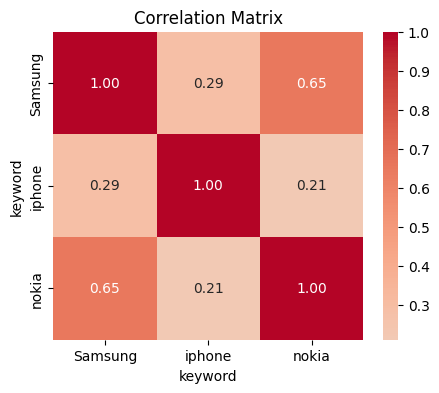

In [28]:
# Correlation matrix
correlation_matrix = heatmap_matrix.corr()

plt.figure(figsize=(5, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()

In [29]:
#Average interest for each keyword
average_interest = data.drop(columns=['date']).mean()

# pie chart
fig = px.pie(values=average_interest, names=average_interest.index, title='Average Interest Distribution Over the Last 5 Years')
fig.update_layout(width=600, height=500)
fig.show()

In [30]:
# scatter plot for each pair of keywords
keywords = data.columns[1:]

for i in range(len(keywords) - 1):
    for j in range(i + 1, len(keywords)):
        keyword1 = keywords[i]
        keyword2 = keywords[j]

        fig = px.scatter(data, x=keyword1, y=keyword2, title=f'Relationship Between {keyword1} and {keyword2} Interest levels over time',
                         labels={keyword1: f'{keyword1} Interest Level', keyword2: f'{keyword2} Interest Level'},
                         trendline="ols", hover_name='date')
        fig.update_layout(width=800, height=600)
        fig.show()

# Analysing Seasonal trends

In [31]:
from statsmodels.tsa.seasonal import seasonal_decompose

<Figure size 1000x800 with 0 Axes>

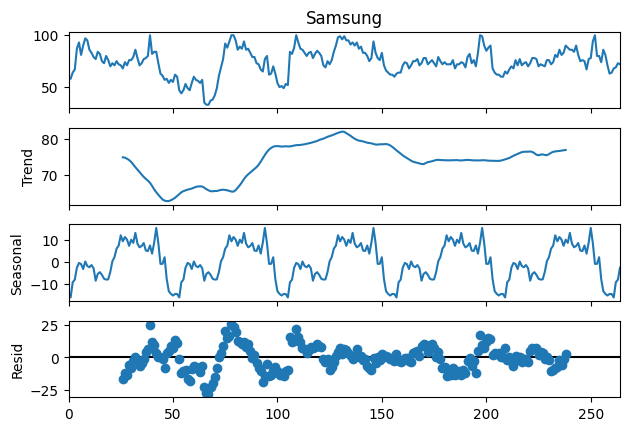

<Figure size 1000x800 with 0 Axes>

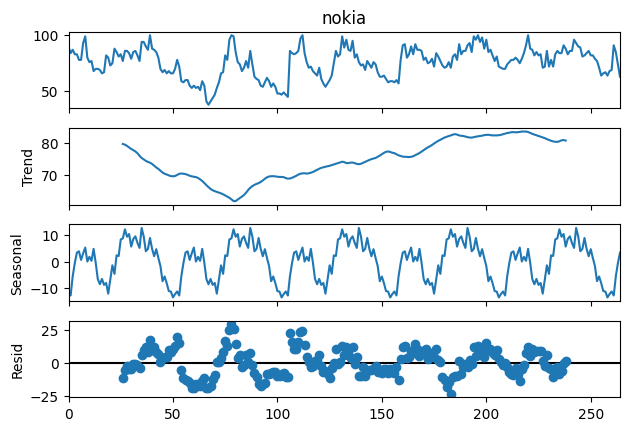

<Figure size 1000x800 with 0 Axes>

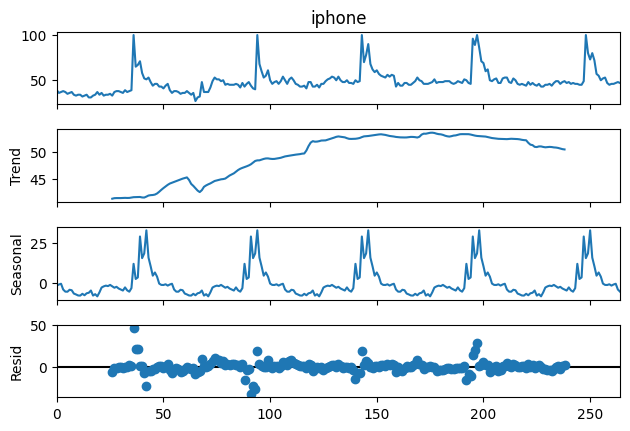

In [32]:
for column in data.columns[1:]:
    try:
        result = seasonal_decompose(data[column], model='additive', period=52)

        plt.figure(figsize=(10, 8))
        plt.suptitle(f'Time Series Decomposition for {column}', fontsize=16)
        result.plot()
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

    except Exception as e:
        print(f"An error occurred while processing {column}: {e}")

In [33]:
# Top 5 states for highest Trend
top_states = {}

for keyword in keywords:
    pytrends.build_payload([keyword], geo='IN', timeframe='today 5-y')
    interest_by_region = pytrends.interest_by_region(resolution='REGION', inc_low_vol=True)

    top_states[keyword] = interest_by_region.sort_values(by=keyword, ascending=False).head(5)

top_states_df = pd.concat(top_states)
print(top_states_df)

                         Samsung  nokia  iphone
        geoName                                
Samsung Gujarat            100.0    NaN     NaN
        Punjab              97.0    NaN     NaN
        Daman and Diu       92.0    NaN     NaN
        Jammu & Kashmir     91.0    NaN     NaN
        Puducherry          88.0    NaN     NaN
nokia   Odisha               NaN  100.0     NaN
        Tamil Nadu           NaN   88.0     NaN
        Puducherry           NaN   86.0     NaN
        Kerala               NaN   86.0     NaN
        Karnataka            NaN   78.0     NaN
iphone  Punjab               NaN    NaN   100.0
        Chandigarh           NaN    NaN    97.0
        Mizoram              NaN    NaN    78.0
        Sikkim               NaN    NaN    76.0
        Delhi                NaN    NaN    73.0


In [34]:
# Future work:-
"""
  - Time series forecasting
  - Event impact analysis(festivals, product launches etc..)
  - Tracking of Marketing campaigns
  - Build user friendly interface
"""

'\n  - Time series forecasting\n  - Event impact analysis(festivals, product launches etc..)\n  - Tracking of Marketing campaigns\n  - Build user friendly interface\n'